In [1]:
import os
os.chdir("D:\\אוניברסיטה\\מעבדה\\Project - Maya\\Anomaly_Detection_In_Microbiome_Proj")
import sys
import pandas as pd
import numpy as np
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import MicrobiomeIsolationForest
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import copy
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu
from sklearn import ensemble
from sklearn.metrics import roc_auc_score
from scipy.spatial import distance
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.ensemble import IsolationForest
import datetime

from joblib import Parallel, delayed
from multiprocessing import cpu_count

from sklearn.mixture import GaussianMixture
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
def read_files(location, sample_size, num_of_outliers):
    dataset_res = {outlier_num : pd.read_csv(location + "_50_%i.csv" % outlier_num, index_col=0) for outlier_num in num_of_outliers}
    dataset_res = {outlier_num: dataset_res[outlier_num][(dataset_res[outlier_num]["weights"] == "equal") & (dataset_res[outlier_num]["pc_method"] == "proportion") & (dataset_res[outlier_num]["replacement"] == True) & (dataset_res[outlier_num]["subsample_size"] == sample_size)] for outlier_num in dataset_res.keys()}
    return dataset_res

def add_auc(res_dict, dataset, all_res_auc = None):
    if all_res_auc is None:
        all_res_auc = pd.DataFrame(columns = ["dataset", "mifo_iso", "num_of_anomalies", "score"])
    
    for anomaly_num in res_dict:
        tmp_dict = {"dataset": dataset, "mifo_iso": "KADAIF", "num_of_anomalies": anomaly_num, 
                "score": roc_auc_score(res_dict[anomaly_num]["anomaly"], res_dict[anomaly_num]["score"])}
        all_res_auc = pd.concat([all_res_auc, pd.DataFrame.from_dict(tmp_dict, orient = "index").T], ignore_index=True)
        
        tmp_dict = {"dataset": dataset, "mifo_iso": "IF", "num_of_anomalies": anomaly_num, 
                "score": roc_auc_score(res_dict[anomaly_num]["anomaly"], res_dict[anomaly_num]["iso"])}
        all_res_auc = pd.concat([all_res_auc, pd.DataFrame.from_dict(tmp_dict, orient = "index").T], ignore_index=True)
        # tmp_dict = {"dataset": dataset, "mifo_iso": "CLOUD", "num_of_anomalies": anomaly_num, 
        #         "score": roc_auc_score(res_dict[anomaly_num]["anomaly"], res_dict[anomaly_num]["CLOUD_score"])}
        # all_res_auc = pd.concat([all_res_auc, pd.DataFrame.from_dict(tmp_dict, orient = "index").T], ignore_index=True)

        
    return all_res_auc

def add_depth(res_dict, dataset, all_res_depth = None):
    
    for anomaly_num in res_dict.keys():
        tmp_res = copy.deepcopy(res_dict[anomaly_num])
        tmp_res["anomaly_num"] = anomaly_num
        tmp_res["dataset"] = dataset
        if all_res_depth is None:
            all_res_depth = tmp_res
        else:
            all_res_depth = pd.concat([all_res_depth,tmp_res], ignore_index = True)
    return all_res_depth

In [3]:
res_wang = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/metabolome/wang_metabolome/results/new_wang_metabolome", 100, [1,2,3,4,5,10,15,20, 25])

res_franzosa = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/metabolome/franzosa_metabolome/results/new_fran_metabolome", 100, [1,2,3,4,5,10,15, 20, 25])

res_tcga_meth = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/metabolome/TCGA_breast/results_meth/new_tcga_breast_meth", 100, [1,2,3,4,5,10,15])

res_tcga_mrna = read_files("D:/אוניברסיטה/מעבדה/Project - Maya/metabolome/TCGA_breast/results_mrna/new_tcga_breast_mrna", 100, [1,2,3,4,5,10, 15])


In [4]:
auc_df = None
depth_df = None

auc_df = add_auc(res_franzosa, "Franzosa Metabolome")
depth_df = add_depth(res_franzosa, "Franzosa Metabolome")


auc_df = add_auc(res_wang, "Wang Metabolome", auc_df)
depth_df = add_depth(res_wang, "Wang Metabolome", depth_df)


auc_df = add_auc(res_tcga_meth, "TCGA Methylation", auc_df)
depth_df = add_depth(res_tcga_meth, "TCGA Methylation", depth_df)

auc_df = add_auc(res_tcga_mrna, "TCGA mRNA", auc_df)
depth_df = add_depth(res_tcga_mrna, "TCGA mRNA", depth_df)



depth_df.reset_index(drop=True, inplace=True)
auc_df["anomaly_precentage"] = auc_df["num_of_anomalies"] * 2
depth_df["anomaly_precentage"] = depth_df["anomaly_num"] * 2

auc_df.iloc[:50]


,dataset,mifo_iso,num_of_anomalies,score,anomaly_precentage
0,Franzosa Metabolome,KADAIF,1,0.922416,2
1,Franzosa Metabolome,IF,1,0.887788,2
2,Franzosa Metabolome,KADAIF,2,0.893108,4
3,Franzosa Metabolome,IF,2,0.877329,4
4,Franzosa Metabolome,KADAIF,3,0.892844,6
5,Franzosa Metabolome,IF,3,0.85539,6
6,Franzosa Metabolome,KADAIF,4,0.891108,8
7,Franzosa Metabolome,IF,4,0.850898,8
8,Franzosa Metabolome,KADAIF,5,0.873463,10
9,Franzosa Metabolome,IF,5,0.842389,10


In [5]:
auc_df.columns = ["dataset", "Method", "num_of_anomalies", "AUC", "Anomaly percentage"]

In [6]:
palette = {50: "#CAF0F8", 40: "#ADE8F4", 30: "#90E0EF", 20: "#48CAE4", 10: "#48CAE4", 
                             8: "#00B4D8", 6: "#0096C7", 4: "#0077B6", 2: "#023E8A", "Normal": "#FF2B1B"}

<Figure size 1000x2000 with 0 Axes>

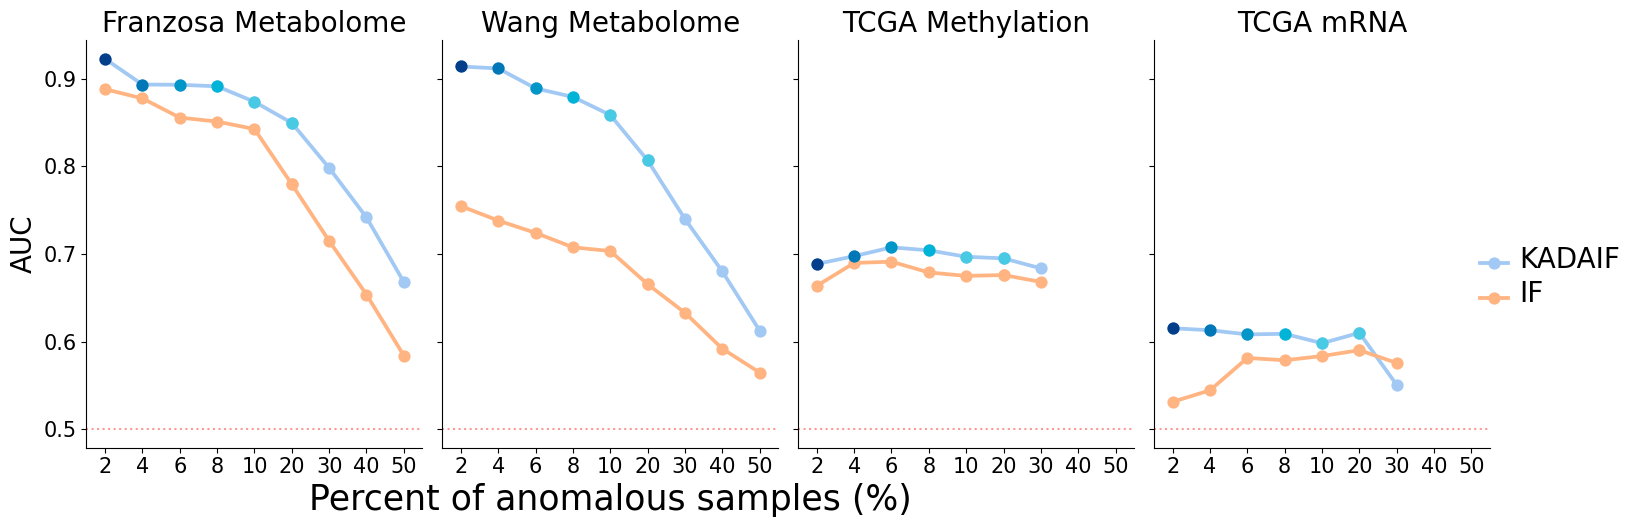

In [20]:
auc_df["Anomaly percentage"] = auc_df["Anomaly percentage"].astype(int)
tmp_auc_df = auc_df[auc_df["Anomaly percentage"] <= 20]
tmp_auc_df2 = auc_df[auc_df["Anomaly percentage"] >= 20]
plt.figure(figsize=(10,20))
g = sns.catplot(x="Anomaly percentage", y="AUC", hue="Method", col="dataset", kind = "point",
                aspect=0.75, palette = "pastel", errorbar = "sd", col_order= ["Franzosa Metabolome", "Wang Metabolome", "TCGA Methylation",
                                                                             "TCGA mRNA"],
               data=tmp_auc_df)

for ax, col_name in zip(g.axes.flat, g.col_names):
    sns.pointplot(
        x="Anomaly percentage", y="AUC", hue="Method", data=tmp_auc_df2[tmp_auc_df2["dataset"] == col_name],
        ax=ax, palette="pastel", errorbar="sd"#, linestyles="dotted"
    )
    for anomal_perc in [2,4, 6, 8, 10, 20]:
        sns.pointplot(
        x="Anomaly percentage", y="AUC", 
            data=tmp_auc_df[(tmp_auc_df["dataset"] == col_name) & (tmp_auc_df["Anomaly percentage"] == anomal_perc) & (tmp_auc_df["Method"] == "KADAIF")],
            ax=ax,  errorbar="sd", color= palette[anomal_perc]
    )

g.set_titles("{col_name}", size=20)  # Here, 'col_name' will be replaced by the value of the dataset column


# Increase the font size for the axis ticks
counter = 0
for ax in g.axes.flat:
    ax.tick_params(labelsize= 15)  

    # Increase the axis title size
      # Set the size of the x-axis title
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    if counter == 1:
        ax.set_xlabel("Percent of anomalous samples (%)", fontsize=25)
    else:
        ax.set_xlabel("", fontsize=0)
    counter += 1

    ax.legend_.remove()
    ax.axhline(y = 0.5, color = 'r', linestyle = 'dotted', alpha = 0.4) 
    
plt.ylabel("AUC", fontsize = 20)
    
g._legend.set_title("", prop={'size': 0})
for text in g._legend.texts:
    text.set_fontsize('20')  # Set text fontsize
g._legend.set_bbox_to_anchor((1.02, 0.5))  # Moves the legend to the right of the figure
# for handle in g._legend.legendHandles:
    # handle.set_sizes([50])  # Optionally add a frame around the legend

# for ax, (col_name, subset_data) in zip(g.axes.flat, auc_df.groupby('dataset')):
#     groups = ["KADAIF"]
#     colors = sns.color_palette("husl", len(groups))  # Choose a color palette
    
#     for group, color in zip(groups, colors):
#         group_data = subset_data[subset_data['Method'] == group].groupby(by = ["dataset",  "Method", "num_of_anomalies"]).mean()
#         for i in range(group_data.shape[0]):
#             ax.plot(group_data["AUC"].iloc[i], group_data["Anomaly percentage"].iloc[i], size = 1000)
# ax.scatter(data = group_data,
        #     x = 'Anomaly percentage', 
        #     y = 'AUC', 
        #     color=color, 
        #     zorder=3  # Ensure points are above lines
        # )
        
    # Optionally, you can add the legend per subplot



# plt.gcf().text(-0.025, 0.98, 'A', fontsize=40, fontweight='bold', ha='left', va='top')



plt.savefig(r"D:\אוניברסיטה\מעבדה\Project - Maya\figures\fig4A_1000dpi_corr.jpg", bbox_inches='tight', dpi=1000)
plt.show()

<Figure size 1000x2000 with 0 Axes>

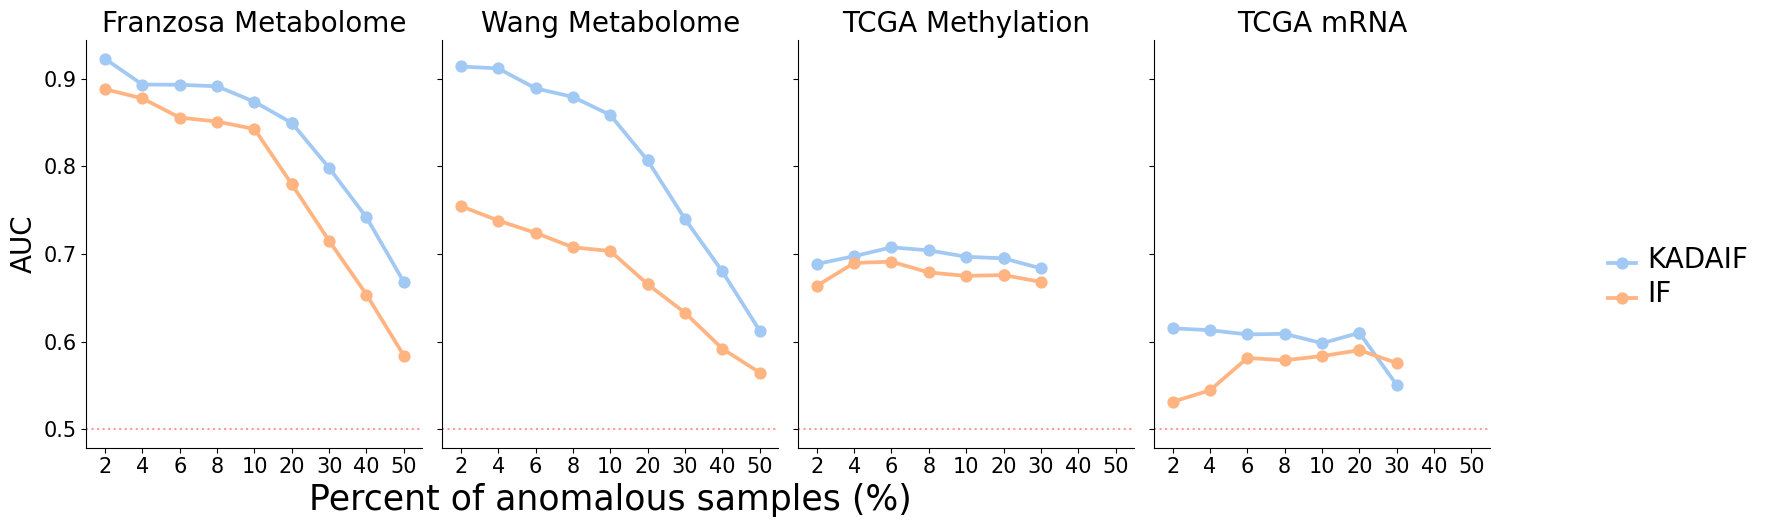

In [8]:
auc_df["Anomaly percentage"] = auc_df["Anomaly percentage"].astype(int)
tmp_auc_df = auc_df[auc_df["Anomaly percentage"] <= 20]
tmp_auc_df2 = auc_df[auc_df["Anomaly percentage"] >= 20]
plt.figure(figsize=(10,20))
g = sns.catplot(x="Anomaly percentage", y="AUC", hue="Method", col="dataset", kind = "point",
                aspect=0.75, palette = "pastel", errorbar = "sd", col_order= ["Franzosa Metabolome", "Wang Metabolome", "TCGA Methylation", "TCGA mRNA"],
               data=tmp_auc_df)

for ax, col_name in zip(g.axes.flat, g.col_names):
    sns.pointplot(
        x="Anomaly percentage", y="AUC", hue="Method", data=tmp_auc_df2[tmp_auc_df2["dataset"] == col_name],
        ax=ax, palette="pastel", errorbar="sd"#, linestyles="dotted"
    )
    # for anomal_perc in [2,4, 6, 8, 10, 20]:
    #     sns.pointplot(
    #     x="Anomaly percentage", y="AUC", 
    #         data=tmp_auc_df[(tmp_auc_df["dataset"] == col_name) & (tmp_auc_df["Anomaly percentage"] == anomal_perc) & (tmp_auc_df["Method"] == "KADAIF")],
    #         ax=ax,  errorbar="sd", color= palette[anomal_perc]
    # )

g.set_titles("{col_name}", size=20)  # Here, 'col_name' will be replaced by the value of the dataset column


# Increase the font size for the axis ticks
counter = 0
for ax in g.axes.flat:
    ax.tick_params(labelsize= 15)  

    # Increase the axis title size
      # Set the size of the x-axis title
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    if counter == 1:
        ax.set_xlabel("Percent of anomalous samples (%)", fontsize=25)
    else:
        ax.set_xlabel("", fontsize=0)
    counter += 1

    ax.legend_.remove()
    ax.axhline(y = 0.5, color = 'r', linestyle = 'dotted', alpha = 0.4) 
    
plt.ylabel("AUC", fontsize = 20)
    
g._legend.set_title("", prop={'size': 0})
for text in g._legend.texts:
    text.set_fontsize('20')  # Set text fontsize
g._legend.set_bbox_to_anchor((1.1, 0.5))  # Moves the legend to the right of the figure
# for handle in g._legend.legendHandles:
    # handle.set_sizes([50])  # Optionally add a frame around the legend

# for ax, (col_name, subset_data) in zip(g.axes.flat, auc_df.groupby('dataset')):
#     groups = ["KADAIF"]
#     colors = sns.color_palette("husl", len(groups))  # Choose a color palette
    
#     for group, color in zip(groups, colors):
#         group_data = subset_data[subset_data['Method'] == group].groupby(by = ["dataset",  "Method", "num_of_anomalies"]).mean()
#         for i in range(group_data.shape[0]):
#             ax.plot(group_data["AUC"].iloc[i], group_data["Anomaly percentage"].iloc[i], size = 1000)
# ax.scatter(data = group_data,
        #     x = 'Anomaly percentage', 
        #     y = 'AUC', 
        #     color=color, 
        #     zorder=3  # Ensure points are above lines
        # )
        
    # Optionally, you can add the legend per subplot



# plt.gcf().text(-0.025, 0.98, 'A', fontsize=40, fontweight='bold', ha='left', va='top')



plt.savefig(r"D:\אוניברסיטה\מעבדה\Project - Maya\figures\fig4_proposal.jpg", bbox_inches='tight', dpi=1000)
plt.show()

In [16]:
only_anomalies = depth_df[depth_df["anomaly"]]
only_norms = depth_df[~depth_df["anomaly"]]
only_norms = only_norms[only_norms["anomaly_precentage"] == 2]
only_norms["anomaly_precentage"] = "Normal"

anomalies_norms_concat = pd.concat([only_anomalies, only_norms])
anomalies_norms_concat = anomalies_norms_concat[~anomalies_norms_concat["anomaly_precentage"].isin([30, 40, 50])]


<Figure size 1000x2000 with 0 Axes>

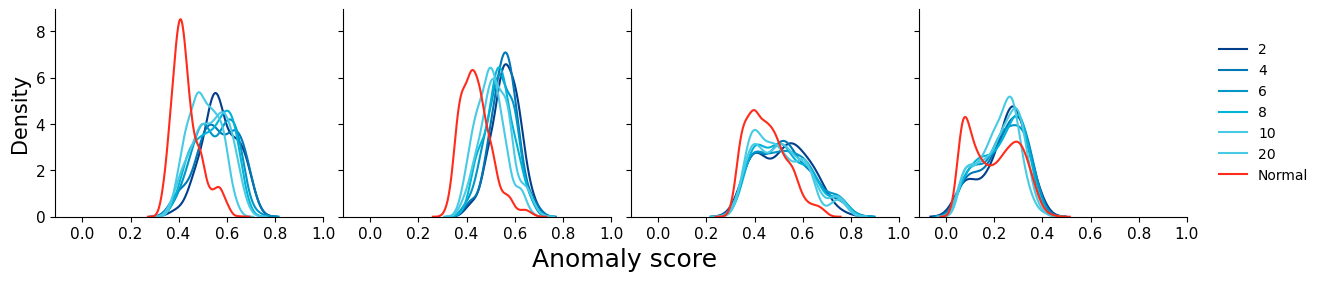

In [11]:
### palette https://coolors.co/palette/03045e-023e8a-0077b6-0096c7-00b4d8-48cae4-90e0ef-ade8f4-caf0f8
plt.figure(figsize=(10,20), constrained_layout=True)

g = sns.FacetGrid(data = anomalies_norms_concat, col="dataset", hue = "anomaly_precentage", 
                  palette = palette,
                  col_order= ["Franzosa Metabolome", "Wang Metabolome", "TCGA Methylation", "TCGA mRNA"]
                 )
g.map(sns.kdeplot, "score")
plt.legend(frameon=False, prop={'size': 15}).set_bbox_to_anchor((1.7, 1.4))
plt.ylabel("Density", fontsize = 20)

counter = 0
g.set_titles("", size = 14)
for ax in g.axes.flat:
    ax.get_xaxis().set_ticks([0,0.2,0.4,0.6,0.8, 1])
    ax.tick_params(labelsize= 11)  

    # Increase the axis title size
    ax.set_ylabel(ax.get_ylabel(), fontsize=15)
    if counter == 1:
        ax.set_xlabel("                                     Anomaly score", fontsize=18)
    else:
        ax.set_xlabel("", fontsize=0)
    counter += 1
# plt.gcf().text(-0.02, 1, 'B', fontsize=29, fontweight='bold', ha='left', va='top')
# plt.figure(figsize=size)
ax.legend(bbox_to_anchor=(1.5, 0.9), frameon=False)
plt.savefig(r"D:\אוניברסיטה\מעבדה\Project - Maya\figures\fig4B_1000dpi_corr.jpg", bbox_inches='tight', dpi = 1000)
plt.show()
# sns.lineplot(data = auc_df, x = "num_of_anomalies", y = "score", hue = "mifo_iso")

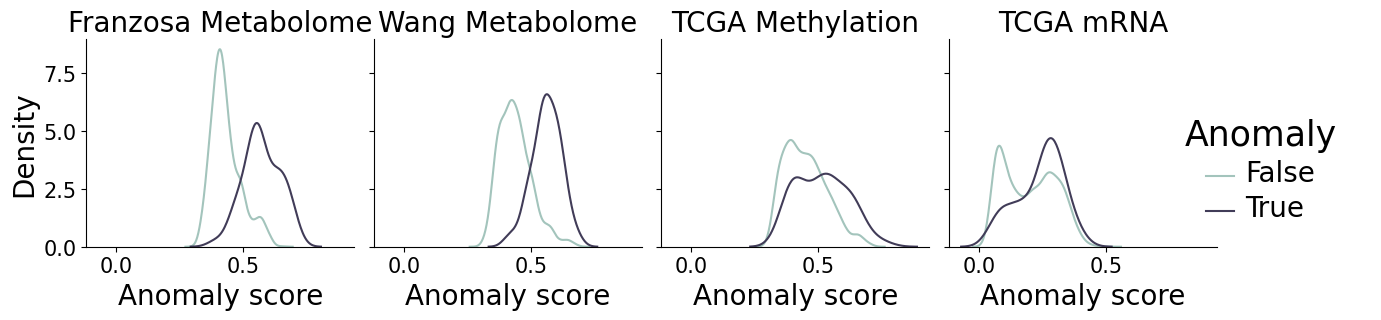

In [11]:
g = sns.FacetGrid(depth_df[depth_df["anomaly_precentage"] == 2], col="dataset", hue = "anomaly", 
                  palette = {True: "#413C58", False: "#A3C4BC"})
g.map(sns.kdeplot, "score", )
g.set_titles("{col_name}", size=20)

g.add_legend()
g._legend.set_title("Anomaly", prop={'size': 25})
for text in g._legend.texts:
    text.set_fontsize('20')  # Set text fontsize
g._legend.set_bbox_to_anchor((1.05, 0.5))  # Moves the legend to the right of the figure


for ax in g.axes.flat:
    ax.tick_params(labelsize= 15)  

    # Increase the axis title size
    ax.set_xlabel("Anomaly score", fontsize=20)  # Set the size of the x-axis title
    ax.set_ylabel("Density", fontsize=20) 


plt.show()


In [12]:
g = sns.factorplot(x="anomaly_precentage", y="score", hue="mifo_iso", col="dataset",
                size=4, aspect=0.75, palette = {"mifo": "#001242", "iso": "#0094C6"},
               data=auc_df)
g.set_titles("{col_name}", size=20)  # Here, 'col_name' will be replaced by the value of the dataset column


# Increase the font size for the axis ticks
counter = 0
for ax in g.axes.flat:
    ax.tick_params(labelsize= 15)  

    # Increase the axis title size
    ax.set_xlabel(ax.get_xlabel(), fontsize=0)  # Set the size of the x-axis title
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    if counter == 2:
        ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    counter += 1

    
g._legend.set_title("mifo_iso", prop={'size': 25})
for text in g._legend.texts:
    text.set_fontsize('20')  # Set text fontsize
g._legend.set_bbox_to_anchor((1.05, 0.5))  # Moves the legend to the right of the figure
for handle in g._legend.legendHandles:
    handle.set_sizes([50])  # Optionally add a frame around the legend
    
plt.show()


AttributeError: module 'seaborn' has no attribute 'factorplot'

In [ ]:
g = sns.FacetGrid(data = depth_df[depth_df["anomaly"]], col="dataset", hue = "anomaly_precentage")
g.map(sns.kdeplot, "score")
plt.legend()
plt.show()
# sns.lineplot(data = auc_df, x = "num_of_anomalies", y = "score", hue = "mifo_iso")

In [ ]:
sns.boxplot(data = depth_df[depth_df["anomaly"]], x = "dataset", y = "score", hue = "anomaly_precentage", whis = 0,
           fliersize = 0)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = "Anomaly precentage")
plt.show()

In [ ]:
sns.boxplot(data = depth_df[~depth_df["anomaly"]], x = "dataset", y = "score", hue = "anomaly_precentage", whis = 0,
           fliersize = 0)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = "Anomaly precentage")
plt.show()